In [1]:
import getpass
import os

if not os.environ.get("GROQ_API_KEY"):
  os.environ["GROQ_API_KEY"] = getpass.getpass("Enter API key for Groq: ")

In [2]:
from langchain.chat_models import init_chat_model

llm = init_chat_model("llama3-8b-8192", model_provider="groq")

In [3]:
from langchain_chroma import Chroma
from langchain_huggingface import HuggingFaceEmbeddings

embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")

vectorstore  = Chroma(
    persist_directory="./recipe_chroma_db",
    collection_name="recipes",
    embedding_function=embeddings,
)

print("目前資料筆數：", vectorstore ._collection.count())


目前資料筆數： 251


In [4]:
retriever = vectorstore .as_retriever()

In [5]:
from langchain import hub

prompt = hub.pull("rlm/rag-prompt")

c:\Users\clair\anaconda3\envs\LLM\Lib\site-packages\langsmith\client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [6]:
from typing import Literal

from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

from pydantic import BaseModel, Field

In [16]:
### 檢索結果評分器


# 資料模型
class GradeDocuments(BaseModel):
    """對檢索到的文件相關性做二元評分。"""

    binary_score: Literal["yes", "no"] = Field(
        description="判斷文件是否與問題相關，填入 'yes' 或 'no'"
    )


# 具結構化輸出的 LLM
structured_llm_grader = llm.with_structured_output(GradeDocuments)

# 提示語（Prompt）
system = """你是一個評分員，負責判斷檢索到的文件是否和使用者問題相關。\n
如果文件符合使用者的條件，請評分為相關（yes）。\n
不需太過嚴謹，目標是過濾掉不正確與不符合使用者條件的檢索結果。\n
請用二元評分 'yes' 或 'no' 來表示文件是否相關。"""
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "檢索到的文件內容：\n\n{document}\n\n使用者問題：{question}"),
    ]
)

retrieval_grader = grade_prompt | structured_llm_grader
question = "梅果口味的食譜有哪些？"
docs = retriever.invoke(question)
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

binary_score='no'


In [17]:
### Generate

from langchain import hub
from langchain_core.output_parsers import StrOutputParser

# Prompt
prompt = hub.pull("rlm/rag-prompt")

# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


# Chain
rag_chain = prompt | llm | StrOutputParser()

# Run
generation = rag_chain.invoke({"context": docs, "question": question})
print(generation)

c:\Users\clair\anaconda3\envs\LLM\Lib\site-packages\langsmith\client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


梅果口味的食譜有：酒漬果乾雪Q餅、蔓越莓雪Q餅、雪Q餅等。


In [ ]:
### 問題改寫器

# 提示語
system = """你是一個問題改寫器，負責將輸入的問題轉換成更優化的版本，\n
    以便在向量資料庫檢索時有更好的效果。請根據輸入問題，推理其背後的語意與意圖。"""

re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "這是原始問題：\n\n{question}\n請重新表述成更好的問題，請使用繁體中文提問。",
        ),
    ]
)

question_rewriter = re_write_prompt | llm | StrOutputParser()
question_rewriter.invoke({"question": question})

'After analyzing the original question, I\'ve rephrased it into a more optimized version:\n\n"Can you provide a list of recipes that feature the flavor profile of guava (梅果) as a primary or notable ingredient?"\n\nHere\'s my thought process:\n\n1. I kept the core idea of the original question, which is to find recipes that feature guava flavor.\n2. I rephrased the question to make it more specific and clear about the type of recipes being sought.\n3. I used technical terms like "flavor profile" and "primary or notable ingredient" to make the question more concise and precise.\n4. I avoided using colloquial language and simplified the question to make it more machine-readable.\n\nThis rephrased question can be more effectively searched in a vector database, as it provides a clearer understanding of the intended search query.'

In [19]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict


class GraphState(TypedDict):
    question: str
    generation: str
    documents: List[str]

In [ ]:
def retrieve(state):
    """
    取得文件

    參數:
        state (dict): 當前的狀態字典

    回傳:
        state (dict): 新增 key 'documents'，包含檢索到的文件
    """
    print("---檢索文件中---")
    question = state["question"]

    # 執行檢索
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}


def generate(state):
    """
    產生回答

    參數:
        state (dict): 當前的狀態字典

    回傳:
        state (dict): 新增 key 'generation'，包含 LLM 產生的回答
    """
    print("---產生回答中---")
    question = state["question"]
    documents = state["documents"]

    # 使用 RAG 生成回答
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}


In [ ]:

def grade_documents(state):
    """
    判斷檢索到的文件是否與問題相關

    參數:
        state (dict): 當前的狀態字典

    回傳:
        state (dict): 更新 'documents'，只包含通過相關性篩選的文件
    """
    print("---評分文件與問題的相關性---")
    question = state["question"]
    documents = state["documents"]

    # 評分每份文件
    filtered_docs = []
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        if grade == "yes":
            print("---評分結果：文件相關---")
            filtered_docs.append(d)
        else:
            print("---評分結果：文件不相關，跳過---")
            continue
    return {"documents": filtered_docs, "question": question}


def transform_query(state):
    """
    改寫查詢問題，產生更好的問題

    參數:
        state (dict): 當前的狀態字典

    回傳:
        state (dict): 更新 'question'，為改寫後的問題
    """
    print("---改寫查詢問題中---")
    question = state["question"]
    documents = state["documents"]

    # 改寫問題
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}


def decide_to_generate(state):
    """
    判斷是要產生回答，還是重新改寫問題

    參數:
        state (dict): 當前的狀態字典

    回傳:
        str: 決定下一個節點要呼叫的名稱（"generate" 或 "transform_query"）
    """
    print("---評估已評分的文件---")
    question = state["question"]
    filtered_documents = state["documents"]

    if not filtered_documents:
        # 所有文件皆不相關，需重新改寫問題
        print("---決策：所有文件不相關，改寫查詢問題---")
        return "transform_query"
    else:
        # 有相關文件，產生回答
        print("---決策：有相關文件，產生回答---")
        return "generate"

In [ ]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("generate", generate)  # generate

# Build graph
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "generate")
workflow.add_edge("generate", END)

# Compile
app = workflow.compile()

In [ ]:
# from langgraph.graph import END, StateGraph, START

# workflow = StateGraph(GraphState)

# # Define the nodes
# workflow.add_node("retrieve", retrieve)  # retrieve
# workflow.add_node("grade_documents", grade_documents)  # grade documents
# workflow.add_node("generate", generate)  # generate
# workflow.add_node("transform_query", transform_query)  # transform_query

# # Build graph
# workflow.add_edge(START, "retrieve")
# workflow.add_edge("retrieve", "grade_documents")
# workflow.add_conditional_edges(
#     "grade_documents",
#     decide_to_generate,
#     {
#         "transform_query": "transform_query",
#         "generate": "generate",
#     },
# )
# workflow.add_edge("transform_query", "retrieve")
# workflow.add_edge("generate", END)

# # Compile
# app = workflow.compile()

In [22]:
# from langgraph.checkpoint.memory import MemorySaver

# memory = MemorySaver()
# app = workflow.compile(checkpointer=memory)

# # Specify an ID for the thread
# config = {"configurable": {"thread_id": "abc123"}}

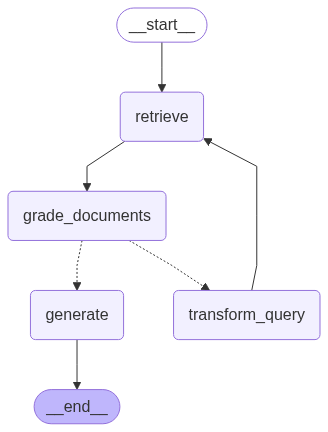

In [23]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [24]:
question = "幫我找一個梅果口味的雪q餅食譜，並告訴我食材和做法。"

for step in app.stream(
    {"question": question}, stream_mode="updates"
):
    print(f"{step}\n\n----------------\n")

---檢索文件中---
{'retrieve': {'documents': [Document(id='346e09a2-ccf9-4a61-8d34-71e9254e5868', metadata={'comment_count': 1, 'date': '2021-02-17', 'like_count': 25, 'recipe_link': 'https://icook.tw/recipes/366461', 'recipe_name': '蔓越莓雪Q餅', 'seq_num': 195, 'source': './output/data_0510_2130.jsonl', 'together_count': 1, 'user_fans_count': 6, 'user_name': 'Wun xiu', 'user_recipe_count': 1, 'view_count': 11000}, page_content='蔓越莓雪Q餅\n描述健康不黏牙的雪Q餅第一次上傳請見諒照片少\n素食, 蔬食\n蔓越莓 50g\n奇福餅乾 5片\n棉花糖 100g\n無鹽奶油 適當\n奶粉 適當\n1. 1.棉花糖剪小塊\n2.蔓越莓對剪\n3.奇福餅乾折小塊（不要太碎）\n2. 加入奶油、奶油融化後加入棉花糖\n拌至融化後 加入奇福餅乾一點奶粉、蔓越莓。\n\n趁熱放盡模子裡（塑膠袋也可以）記得先灑上一點奶粉才不會黏\n鋪平後、冷卻、即可切小塊食用'), Document(id='e8174fcc-a37a-49ed-9580-7467a80d7ac3', metadata={'comment_count': 3, 'date': '2020-02-01', 'like_count': 9, 'recipe_link': 'https://icook.tw/recipes/322235', 'recipe_name': '酒漬果乾雪Q餅', 'seq_num': 202, 'source': './output/data_0510_2130.jsonl', 'together_count': 3, 'user_fans_count': 2, 'user_name': 'Jennifer  Lu', 'user_recipe_count': 1, 'view_cou